# HW2

In [ ]:
import gym
import itertools
import random
import copy
import math
import numpy as np
import matplotlib.pyplot as plt

from itertools import count
from collections import namedtuple, defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:

N_COLS = 3
N_ROWS = 3
N_WIN = 3


class TicTacToe(gym.Env):
    
    def __init__(self, n_rows = N_ROWS, n_cols = N_COLS, n_win = N_WIN):
        
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype = int)
        self.gameOver = False
        self.boardHash = None
        
        # the first gamer step
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

        
    def getEmptySpaces(self):
        
        if self.emptySpaces is None:
            
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([(i, j) for i,j in zip(res[0], res[1])])
            
        return self.emptySpaces

    
    def makeMove(self, player, i, j):
        
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

        
    def getHash(self):
        
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        
        return self.boardHash

    
    def isTerminal(self):
        
        # check if game is finished
        cur_marks = np.where(self.board == self.curTurn)
        cur_p = self.curTurn
        
        for i,j in zip(cur_marks[0], cur_marks[1]):
            
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
                    
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
                        
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
                        
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
                        
            if win:
                self.gameOver = True
                
                return self.curTurn
        
        
        if len(self.getEmptySpaces()) == 0:
            
            self.gameOver = True    
            return 0

        self.gameOver = False
        return None

    
    def printBoard(self):
        
        for i in range(0, self.n_rows):
            
            print('----' * (self.n_cols) + '-')
            out = '| '
            
            for j in range(0, self.n_cols):
                
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
                
            print(out)    
        print('----' * (self.n_cols) + '-')

        
    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    
    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    
    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    
    def step(self, action):
        
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    
    def reset(self):
        
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        

# 1) TicTacToe by Q-learning

In [ ]:

def avail_actions(s):
    
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]


def not_avail_actions(s):
    
    string_array = np.array(list(s))
    return np.where(string_array != '1')[0]


def play_game(env, 
              Q, 
              print_board = False, 
              player1_random = False, 
              player2_random = False):
    
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    result = [0, 0]
    player = 1
    
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(s))
        else:
            action = np.argmax(Q[s])
            
        action_tuple = env.action_from_int(action)
        (s, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        
        if print_board:
            env.printBoard()
        player = player * -1
        
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

    
def evaluate(env, 
             Q, 
             n = 1000, 
             disable_tqdm = False, 
             player1_random = False, 
             player2_random = False):
    
    rewards1 = []
    rewards2 = []
    
    for _ in tqdm(range(n), disable = disable_tqdm):
        
        reward1, reward2 = play_game(env,
                                     Q,
                                     print_board=False,
                                     player1_random = player1_random,
                                     player2_random = player2_random)
        rewards1.append(reward1)
        rewards2.append(reward2)
        
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    
    return r1, r2, no_winner


def get_pi_by_Q(Q):
    
    pi = {k: np.argmax(v) for k, v in Q.items()}
    return defaultdict(int, pi)


class Agent:
    
    def __init__(self, alpha, gamma, s = None, a = None):
        
        self.s = s
        self.a = a
        self.alpha = alpha
        self.gamma = gamma
        
        
    def update_Q(self, Q, state, action, reward):
        
        Q[self.s][self.a] = Q[self.s][self.a] + self.alpha * \
                            (reward + self.gamma * np.max(Q[state]) - Q[self.s][self.a])
        self.s = state
        self.a = action
        
        
def Q_learning_episode(env, 
                       Q, 
                       A, 
                       alpha = 0.05, 
                       epsilon = 0.1, 
                       gamma = 1):
    
    env.reset()
    s, empty_spaces, turn = env.getState()
    agents = (Agent(alpha = alpha, gamma = gamma),
              Agent(alpha = alpha, gamma = gamma))
    done = False
    agent_idx = 0
    
    while not done:
        
        Q[s][not_avail_actions(s)] = -9999
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(avail_actions(s))
        agent = agents[agent_idx]
        agent.update_Q(Q, s, a, 0)
        agent_idx = 1 - agent_idx 
        (s, empty_spaces, turn), r , done, _ = env.step(env.action_from_int(a))    

    if r == -10:
        agent.update_Q(Q, s, a, r)
    else:
        agents[0].update_Q(Q, s, a, r) 
        agents[1].update_Q(Q, s, a, -r) 
        
    return Q


def Q_learning(env, 
               Q, 
               A, 
               episodes = 100_000, 
               alpha = 0.05, 
               evaluate_every = 100, 
               epsilon = 0.3, 
               gamma = 1, 
               disable_tqdm = False):
    
    hist_p1 = []
    hist_p2 = []
    iters = []

    for i in tqdm(range(episodes), disable=disable_tqdm):
        
        Q = Q_learning_episode(env = env, Q = Q, A = A, alpha = alpha, epsilon = epsilon, gamma = gamma)
        if i % evaluate_every == 0:
            
            res_p1 = evaluate(env, Q, n = 100, disable_tqdm = True, player1_random = False, player2_random = True)[0]
            res_p2 = evaluate(env, Q, n = 100, disable_tqdm = True, player1_random = True, player2_random = False)[1]
            hist_p1.append(res_p1)
            hist_p2.append(res_p2)
            iters.append(i)
            
    return Q, (hist_p1, hist_p2), iters


# 1.1 (1) Q-learning. Field 3x3

In [ ]:

env = TicTacToe(n_rows = 3, n_cols = 3, n_win = 3)
env.reset()

game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [ ]:
Q, (hist_p1, hist_p2), iters = Q_learning(env, 
                                          Q, 
                                          A, 
                                          episodes = 30000, 
                                          alpha = 0.01, 
                                          epsilon = 0.7)

100%|██████████| 30000/30000 [00:53<00:00, 558.08it/s]


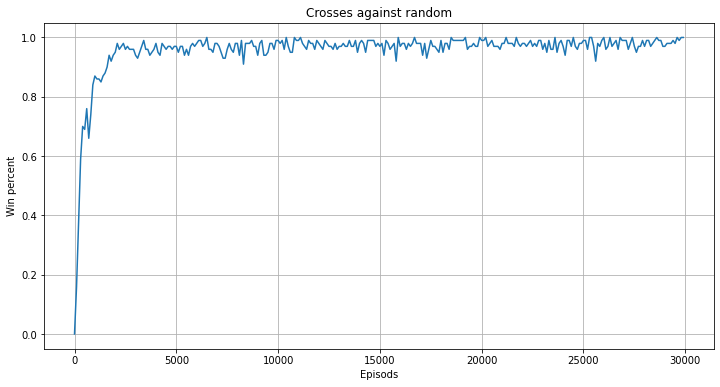

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Crosses against random')
plt.xlabel('Episods')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(iters, hist_p1);

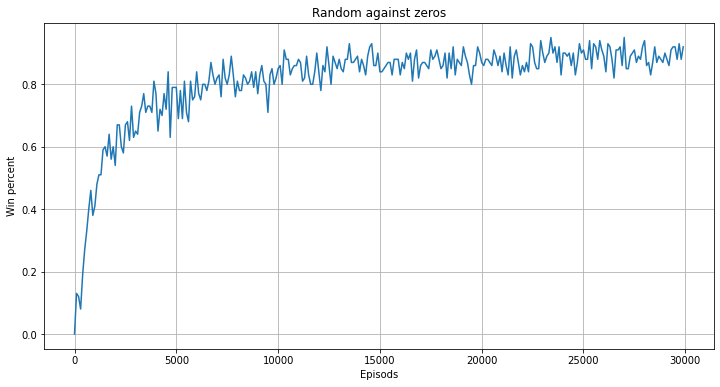

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Random against zeros')
plt.xlabel('Episods')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(iters, hist_p2);

## 1.2 (2) Q-learning. Field 4x4

In [ ]:

env = TicTacToe(n_rows = 4, n_cols = 4, n_win = 4)
env.reset()

game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [ ]:
Q, (hist_p1, hist_p2), iters = Q_learning(env, 
                                          Q, 
                                          A, 
                                          episodes = 500000, 
                                          alpha = 0.05, 
                                          epsilon = 0.7, 
                                          evaluate_every = 1000)

100%|██████████| 500000/500000 [14:59<00:00, 555.94it/s]


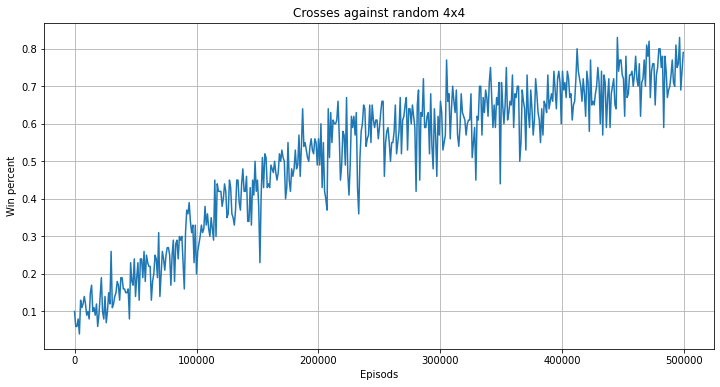

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Crosses against random 4x4')
plt.xlabel('Episods')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(iters, hist_p1);

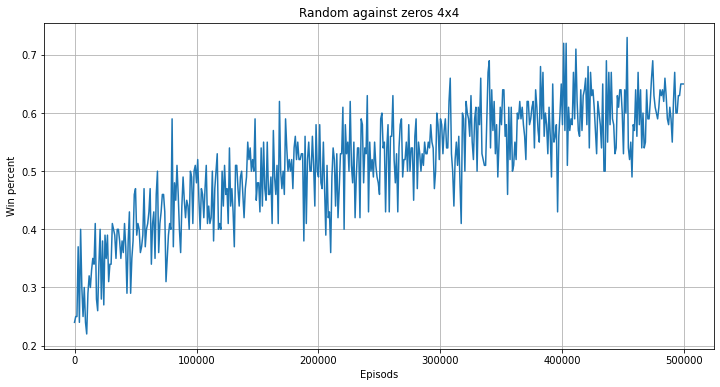

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Random against zeros 4x4')
plt.xlabel('Episods')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(iters, hist_p2);

# We need a lot of time to train for win strategy. Nevertheless, we could see that our strategy is improving in time.

# 2) Add NN (DQN method)

In [ ]:
class ReplayMemory():

    def __init__(self, capacity):

        self.capacity = capacity
        self.memory = []
        self.position = 0


    def store(self, exptuple):

        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    

    def __len__(self):
        return len(self.memory)


class Player:

    def __init__(self, memory_capacity=10000):

        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity = memory_capacity)
    

    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)

        if self.state is not None:
            self.memory.store((self.state, next_state, self.action, reward))

        self.state = next_state
        self.action = action
        

    def new_game(self):
        self.state = None
        self.action = None        

        
def state_to_layers(state):
    return np.array([(state == 1).astype(float), (state == -1).astype(float), (state == 0).astype(float)])
        

def get_action_from_model(model, state):

    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()

    return action


def avail_actions(s):

    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    

def get_action(model, state, game_hash, epsilon):

    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))

    return action
        

def play_game_model(env, model, print_board = False, player1_random = False, player2_random = False):

    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1

    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)

        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        player = player * -1

    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        

def evaluate_model(env, model, n = 1000, disable_tqdm = False, player1_random = False, player2_random = False):
  
    model.eval()
    rewards1 = []
    rewards2 = []

    for _ in tqdm(range(n), disable=disable_tqdm):

        reward1, reward2 = play_game_model(env, 
                                           model, 
                                           print_board = False, 
                                           player1_random = player1_random, 
                                           player2_random = player2_random)
        rewards1.append(reward1)
        rewards2.append(reward2)

    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2

    return r1, r2, no_winner


def train_batch(model, optimizer, criterion, replay_memory, batch_size = 128, gamma = 1):
    
    if len(replay_memory) < batch_size:
        return
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()


def play_episode(env, model1, model2, epsilon, player1, player2):

    env.reset()
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board.copy()
    done = False
    player1.new_game()
    player2.new_game()
    players = (player1, player2)
    models = (model1, model2)
    player_idx = 0
    
    while not done:

        player = players[player_idx]
        model = models[player_idx]
        action = get_action(model, state, game_hash, epsilon)
        player.add_exp(state, action, 0)
        player_idx = 1 - player_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        state = env.board.copy()
        
    if reward == -10:
        player.add_exp(state, action, reward)
    else:
        players[0].add_exp(state, action, reward)
        players[1].add_exp(state, action, -reward)
        

def run_learning(env, model1_tuple, model2_tuple, criterion, episodes = 10000, eps_init = 0.5, batch_size = 64, gamma = 1, model_name = 'dqn'):

    p1, p2 = Player(), Player()
    model1, optimizer1, scheduler1 = model1_tuple
    model2, optimizer2, scheduler2 = model2_tuple
    
    loss_cache_p1 = []
    loss_cache_p2 = []
    hist_p1 = []
    hist_p2 = []
    iters = []
    loss_hist_p1 = []
    loss_hist_p2 = []
    best_result_p1 = 0
    best_result_p2 = 0
    pbar = tqdm(range(episodes))
    
    eps_final = 0.05
    eps_decay = int(episodes / 2)
    
    for i in pbar:
      
        eps_threshold = eps_init

        for _ in range(1):
            play_episode(env, model1, model2, eps_threshold, p1, p2)
        
        loss1 = train_batch(model1, optimizer1, criterion, p1.memory, batch_size = batch_size, gamma = gamma)
        loss2 = train_batch(model2, optimizer2, criterion, p2.memory, batch_size = batch_size, gamma = gamma)

        if loss1 is not None:
            loss_cache_p1.append(loss1)

        if loss2 is not None:
            loss_cache_p2.append(loss2)
        
        if (i + 1) % 100 == 0:

            result_p1, _, _ = evaluate_model(env, model1, n = 200, player1_random = False, player2_random = True, disable_tqdm = True)
            _, result_p2, _ = evaluate_model(env, model2, n = 200, player1_random = True, player2_random = False, disable_tqdm = True)
            
            iters.append(i)
            hist_p1.append(result_p1)
            hist_p2.append(result_p2)
            
            mean_loss_p1 = np.mean(loss_cache_p1) if loss_cache_p1 else 0
            loss_hist_p1.append(mean_loss_p1)
            
            mean_loss_p2 = np.mean(loss_cache_p2) if loss_cache_p2 else 0
            loss_hist_p2.append(mean_loss_p2)
            
            loss_cache_p1 = []
            loss_cache_p2 = []
            
            total_result = result_p1 + result_p2
            if scheduler1 is not None:
                scheduler1.step(mean_loss_p1)
            if scheduler2 is not None:
                scheduler2.step(mean_loss_p2)
            
            pbar.set_postfix({
                'l1': mean_loss_p1, 
                'l2': mean_loss_p2, 
                'p1': result_p1, 
                'p2': result_p2,
                'eps': eps_threshold,
            })

            if best_result_p1 < result_p1:
                torch.save(model1.state_dict(), f'best_{model_name}_p1.pth')
            if best_result_p2 < result_p2:
                torch.save(model2.state_dict(), f'best_{model_name}_p2.pth')
                
    return (hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters 
    

# 2.1 (3) DQN with NN (Tic-Tac-Toe)

# 3x3 Field

In [ ]:
env = TicTacToe(n_rows = 3, n_cols = 3, n_win = 3)

In [ ]:
class DQN_3x3(nn.Module):

    def __init__(self, hidden_size = 512):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = hidden_size, kernel_size = (3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)       
        

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x
        

In [ ]:
model = DQN_3x3().eval()
x = torch.randn(128, 3, 3, 3)
model(x).shape

torch.Size([128, 9])

In [ ]:
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size = HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

model2 = DQN_3x3(hidden_size = HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [ ]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(env, 
                                                                      (model1, optimizer1, None), 
                                                                      (model2, optimizer2, None), 
                                                                      criterion,
                                                                      episodes = 15000, 
                                                                      eps_init = 0.5,
                                                                      batch_size = 256,
                                                                      gamma = 0.7)

100%|██████████| 15000/15000 [14:19<00:00, 17.45it/s, l1=0.0243, l2=0.0384, p1=0.98, p2=0.795, eps=0.5]


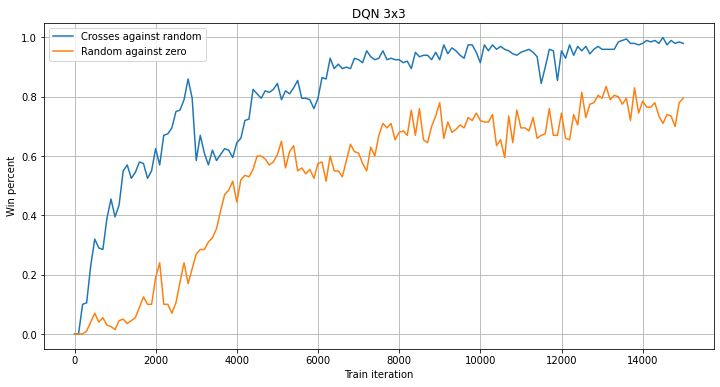

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('DQN 3x3')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Crosses against random')
plt.plot([0] + iters, [0] + hist_p2, label='Random against zero')
plt.legend();

#4x4 Field

In [ ]:
env = TicTacToe(n_rows = 4, n_cols = 4, n_win = 4)

In [ ]:
class DQN_4x4(nn.Module):

    def __init__(self, conv1_channels = 32, conv2_channels = 256):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = conv1_channels, kernel_size = (3, 3))
        self.conv2 = nn.Conv2d(in_channels = conv1_channels, out_channels = conv2_channels, kernel_size = (2, 2))
        self.fc1 = nn.Linear(conv2_channels, conv2_channels)
        self.fc2 = nn.Linear(conv2_channels, 16)
        

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        

In [ ]:
LR = 1e-5
WEIGHT_DECAY = 1e-9
criterion = F.l1_loss

model1 = DQN_4x4()
optimizer1 = optim.Adam(model1.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

model2 = DQN_4x4()
optimizer2 = optim.Adam(model2.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [ ]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(env, 
                                                                       (model1, optimizer1, None), 
                                                                       (model2, optimizer2, None), 
                                                                       criterion,
                                                                       episodes = 30000, 
                                                                       eps_init = 0.5,
                                                                       batch_size = 256,
                                                                       gamma = 0.7)

100%|██████████| 30000/30000 [26:46<00:00, 18.67it/s, l1=0.0307, l2=0.0285, p1=0.94, p2=0.525, eps=0.5]


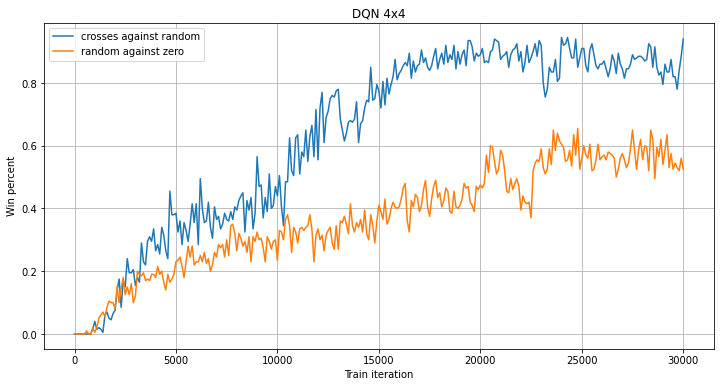

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('DQN 4x4')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='crosses against random')
plt.plot([0] + iters, [0] + hist_p2, label='random against zero')
plt.legend();

#2.2(4) Double DQN and/or Dueling DQN.

In [ ]:
env = TicTacToe(n_rows = 3, n_cols = 3, n_win = 3)

In [ ]:
class DuelingDQN_3x3(nn.Module):

    def __init__(self, hidden_size = 256):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = hidden_size, kernel_size = (3, 3))
        self.V = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 1))
        self.A = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 9))
        
        
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        A = self.A(x)
        V = self.V(x)
        Q = V + (A - A.mean(dim=1, keepdim = True).expand(x.size(0), 9))

        return Q

In [ ]:
model = DuelingDQN_3x3().eval()
x = torch.FloatTensor([state_to_layers(env.board)] * 128)
model(x).shape

torch.Size([128, 9])

In [ ]:
LR = 1e-6
WEIGHT_DECAY = 1e-7
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DuelingDQN_3x3(hidden_size = HIDDEN_SIZE)
optimizer1 = optim.Adam(model1.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

model2 = DuelingDQN_3x3(hidden_size = HIDDEN_SIZE)
optimizer2 = optim.Adam(model2.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [ ]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(env, 
                                                                       (model1, optimizer1, None), 
                                                                       (model2, optimizer2, None), 
                                                                       criterion,
                                                                       episodes = 15000, 
                                                                       eps_init = 0.5,
                                                                       batch_size = 128,
                                                                       model_name = 'dueling_dqn',
                                                                       gamma = 0.7)

100%|██████████| 15000/15000 [13:45<00:00, 18.17it/s, l1=0.0262, l2=0.0482, p1=0.895, p2=0.69, eps=0.5]


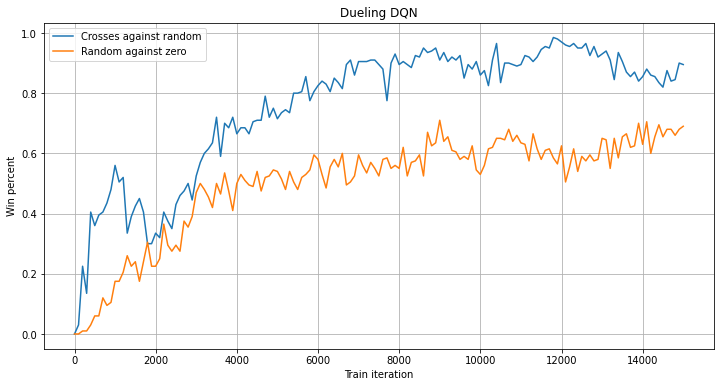

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Dueling DQN')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label = 'Crosses against random')
plt.plot([0] + iters, [0] + hist_p2, label = 'Random against zero')
plt.legend();

# 3) Expand and deepen search

# 3.1(5) Rollouts with random strategy or with determenistic simple strategy

In [ ]:
def rollout(env: TicTacToe, policy):

    env = copy.deepcopy(env)
    state, empty_spaces, turn = env.getState()
    player = -turn
    done = False
    turn_idx = 0

    while not done:

        A = avail_actions(state)
        action = policy(A, state)
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        turn_idx = 1 - turn_idx
        
    return reward * player


def get_rollouts_action(env: TicTacToe, policy, n_iters = 20):

    env_current = copy.deepcopy(env)
    state, empty_spaces, turn = env_current.getState()
    player = turn
    A = avail_actions(state)
    results = dict()

    for action in A:

        env_current = copy.deepcopy(env)
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env_current.step(action_tuple)

        if not done:
            results[action] = np.mean([rollout(env_current, policy) for _ in range(n_iters)])
        else:
            results[action] = reward * player
        
    best_action = max(results, key=results.get)

    return best_action
        

def play_with_rollouts(env: TicTacToe, use_rollouts, policies, n_rollouts):

    env.reset()
    state, empty_spaces, turn = env.getState()
    done = False
    turn_idx = 0
    
    while not done:

        A = avail_actions(state)
        
        if use_rollouts[turn_idx]:
            action = get_rollouts_action(env, policies[turn_idx], n_iters = n_rollouts)
        else:
            action = random.choice(A)
            
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        turn_idx = 1 - turn_idx
        
    return reward


def random_policy(A, state):
    return random.choice(A)


def get_Q_policy(Q_for_policy):
  
    def Q_policy(A, state):

        Qsa = {action: Q_for_policy[state][action] for action in A} 
        best_action = max(Qsa, key = Qsa.get)

        return best_action

    return Q_policy


def evaluate_rollouts(env, use_rollouts = (True, False), policies = (random_policy, random_policy), n_games = 500, n_rollouts = 20):

    wins = defaultdict(int)
    pbar = tqdm(range(n_games))

    for i in pbar:

        reward = play_with_rollouts(env, use_rollouts = use_rollouts, policies = policies, n_rollouts = n_rollouts)
        wins[reward] += 1
        pbar.set_postfix({'X': wins[1] / (i + 1), 'O': wins[-1] / (i + 1), 'draw': wins[0] / (i + 1)})

    return (wins[1] / n_games, wins[-1] / n_games, wins[0] / n_games)

In [ ]:
SIZE = 3
env = TicTacToe(n_rows = SIZE, n_cols = SIZE, n_win = SIZE)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))

rollouts for 3x3

In [ ]:
Q_33 = defaultdict(lambda: np.zeros(len(A)))
Q_33, _, _ = Q_learning(env, Q_33, A, episodes = 50000, alpha = 0.01, epsilon = 0.7, disable_tqdm = False, evaluate_every = 1000000)

100%|██████████| 50000/50000 [00:35<00:00, 1393.30it/s]


#### 1. Crosses with rollouts with random strategy

In [ ]:
crosses, zero, draw = evaluate_rollouts(env, 
                                        use_rollouts = (True, False), 
                                        policies = (random_policy, None), 
                                        n_games = 1000, 
                                        n_rollouts = 50)

print(f'X: {crosses:.3f}, O: {zero:.3f}, draw: {draw:.3f}')

100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s, X=0.988, O=0, draw=0.012]

X: 0.988, O: 0.000, draw: 0.012


#### 2. zeros with rollouts with random strategy

In [ ]:
crosses, zero, draw = evaluate_rollouts(env, 
                                        use_rollouts = (False, True), 
                                        policies = (None, random_policy),
                                        n_games = 1000,
                                        n_rollouts = 50)

print(f'X: {crosses:.3f}, O: {zero:.3f}, draw: {draw:.3f}')

100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s, X=0.05, O=0.882, draw=0.068]

X: 0.050, O: 0.882, draw: 0.068


#### 3 Crosses with rollouts with determenistic strategy (Q from first paragraph)

In [ ]:
crosses, zero, draw = evaluate_rollouts(env,
                                        use_rollouts = (True, False),
                                        policies = (get_Q_policy(Q_33), None),
                                        n_games = 1000,
                                        n_rollouts = 50)

print(f'X: {crosses:.3f}, O: {zero:.3f}, draw: {draw:.3f}')

100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s, X=0.906, O=0.012, draw=0.082]

X: 0.906, O: 0.012, draw: 0.082


#### 4 Zeros with rollouts rollouts with determenistic strategy (Q from first paragraph)

In [ ]:
crosses, zero, draw = evaluate_rollouts(env,
                                        use_rollouts = (False, True), 
                                        policies = (None, get_Q_policy(Q_33)), 
                                        n_games = 1000,
                                        n_rollouts = 50)

print(f'X: {crosses:.3f}, O: {zero:.3f}, draw: {draw:.3f}')

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s, X=0.14, O=0.654, draw=0.206]

X: 0.140, O: 0.654, draw: 0.206


# 3.2(6) MCTS-search with current rollouts for Tic-Tac-Toe on the field with different dimensions. Comparative analysis

In [ ]:
class Node:

    def __init__(self, state, action, player, parent = None, is_new = True):

        self.state = state
        self.action = action
        self.parent = parent
        self.player = player
        self.crosses = 0
        self.zero = 0
        self.visits = 0
        self.children = []
        self.is_new = is_new
        self.is_terminal = False
        

    def value(self):

        if self.visits == 0:
            return 0
        
        node_val = self.crosses if self.player == 1 else self.zero
        return node_val / self.visits
    

    def __repr__(self): 
        return f'X: {self.crosses}, O: {self.zero}, V: {self.visits},  P: {self.player}, S: {self.state}, ' \
            f'A: {self.action}, children:{len(self.children)}, is_terminal: {self.is_terminal}'
        
        
class MCTS:

    def __init__(self, env, exploration_const, policy, player):

        self.env = env
        self.size = self.env.n_rows
        self.C = exploration_const
        self.policy = policy
        self.player = player
        self.env.reset()
        state, empty_spaces, turn = self.env.getState()
        self.root = Node(state = state, action = None, player = -1, parent = None, is_new = False)
        self.hist = [0]
        self.hist_iters = [0]
        
        
    @staticmethod
    def update_state_with_action(s, action, player):

        action_str = str(player + 1)
        new_hash = s[:action] + action_str + s[action + 1:]

        return new_hash
    
    
    def evalueate_tree(self, random_policy, n_games = 5000):

        rewards = []
        for _ in range(n_games):

            node = self.root
            self.env.reset()
            state, empty_spaces, turn = self.env.getState()
            done = False
            turn_idx = 0

            while not done:
                
                if node.children:

                    if random_policy[turn_idx]:
                        child = random.choice(node.children)
                    else:
                        child = max(node.children, key=lambda x: x.value())
                    node = child
                    action = child.action

                else:
                    A = avail_actions(state)
                    action = random.choice(A)
                    
                action_tuple = env.action_from_int(action)
                (state, empty_spaces, turn), reward, done, _ = self.env.step(action_tuple)
                turn_idx = 1 - turn_idx

            rewards.append(reward)

        return rewards.count(1) / n_games, rewards.count(-1) / n_games, rewards.count(0) / n_games
    

    @staticmethod
    def backprop(node, crosses, zero):

        while node is not None:

            node.crosses += crosses
            node.zero += zero
            node.visits += 1
            node = node.parent
            

    def get_child_ucb(self, node):

        ucbs = []
        for child in node.children:

            ucb = child.value() + self.C * np.sqrt(np.log(node.visits) / child.visits)
            ucbs.append(ucb)

        ucb_idx = np.argmax(ucbs)
        best_child = node.children[ucb_idx]

        return best_child
    

    def play_game_from_state(self, state, turn):

        self.env.reset()
        board = np.array([int(c) - 1 for c in state]).reshape(self.size, self.size)
        self.env.board = board
        self.env.curTurn = turn
        is_terminal = False
        done = False
        
        if self.env.isTerminal() is not None:

            reward = self.env.isTerminal()
            done = True
            is_terminal = True        
        
        while not done:

            A = avail_actions(state)
            if self.env.curTurn == self.player:
                action = self.policy(A, state)
            else:
                action = random.choice(A)

            action_tuple = self.env.action_from_int(action)
            (state, empty_spaces, turn), reward, done, _ = self.env.step(action_tuple)
            
        return reward, is_terminal
            
            
    def rollout(self, node):

        if node.is_terminal:

            crosses = int(node.crosses > 0)
            zero = int(node.zero > 0)

            return crosses, zero, node.is_terminal
        
        crosses = 0
        zero = 0
        turn = node.player * -1
        state = node.state
        reward, is_terminal = self.play_game_from_state(state, turn)

        if reward == 1:
            crosses += 1
        if reward == -1:
            zero += 1
        
        return crosses, zero, is_terminal
        

    def learning_step(self):

        node = self.root
        while True:
            
            if node.is_terminal:

                crosses, zero, is_terminal = self.rollout(node)
                node.crosses += crosses
                node.zero += zero
                node.is_terminal = is_terminal
                node.is_new = False
                self.backprop(node, crosses, zero)

                break
                
            possible_actions = set(avail_actions(node.state))
            child_actions = {child.action for child in node.children}
            left_actions = possible_actions - child_actions
            

            if left_actions:

                action = random.choice(list(left_actions))
                new_player = node.player * -1
                new_state = self.update_state_with_action(node.state, action, new_player)
                
                child = Node(state = new_state,
                             action = action,
                             player = new_player,
                             parent = node)
                node.children.append(child)
                
                crosses, zero, is_terminal = self.rollout(child)
                child.crosses += crosses
                child.zero += zero
                child.is_terminal = is_terminal
                child.is_new = False
                self.backprop(child, crosses, zero)
                
            else:

                if node.player == -self.player:
                    child = self.get_child_ucb(node)
                else:
                    child = random.choice(node.children)
                
            node = child
            
            
    def run_learning(self, n_iters = 1000, eval_every = 50):

        pbar = tqdm(range(n_iters))
        for i in pbar:
            self.learning_step()

            if (i + 1) % eval_every == 0:
                self.save_point_history(i, eval_every)
                pbar.set_postfix({'player': self.player, 'win raito': self.hist[-1]})
            

    def save_point_history(self, num_iter, eval_every):
                
        random_policy_flags = (False, True) if self.player == 1 else (True, False)
        res_p1, res_p2, res_nichya = self.evalueate_tree(random_policy=random_policy_flags, n_games=500)
        
        if self.player == 1:
            self.hist.append(res_p1)
        if self.player == -1:
            self.hist.append(res_p2)
            
        self.hist_iters.append(self.hist_iters[-1] + eval_every)
        

### MCTS 3x3

In [ ]:
SIZE = 3
env = TicTacToe(n_rows = SIZE, n_cols = SIZE, n_win = SIZE)
env.reset()
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))

#### For rollout we use strategy from the ferst item

In [ ]:
mcts_p1 = MCTS(env, exploration_const = 1.41, policy = get_Q_policy(Q_33), player = 1)
mcts_p1.run_learning(n_iters = 15000, eval_every = 50)

100%|██████████| 15000/15000 [01:03<00:00, 236.68it/s, player=1, win raito=0.966]


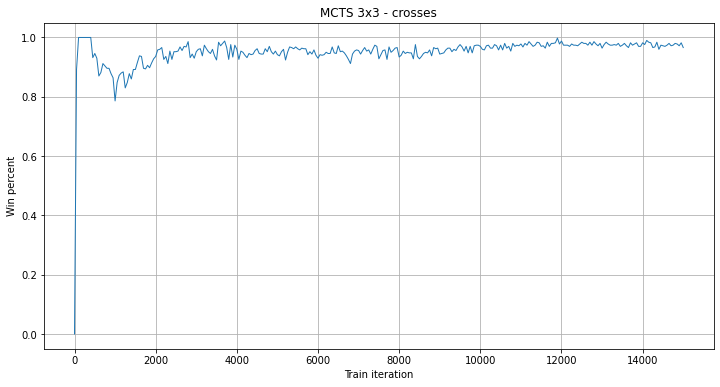

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('MCTS 3x3 - crosses')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(mcts_p1.hist_iters, mcts_p1.hist, lw = 1)

In [ ]:
mcts_p2 = MCTS(env, exploration_const = 1.41, policy = get_Q_policy(Q_33), player = -1)
mcts_p2.run_learning(n_iters = 30000, eval_every = 100)

100%|██████████| 30000/30000 [01:16<00:00, 390.36it/s, player=-1, win raito=0.886]


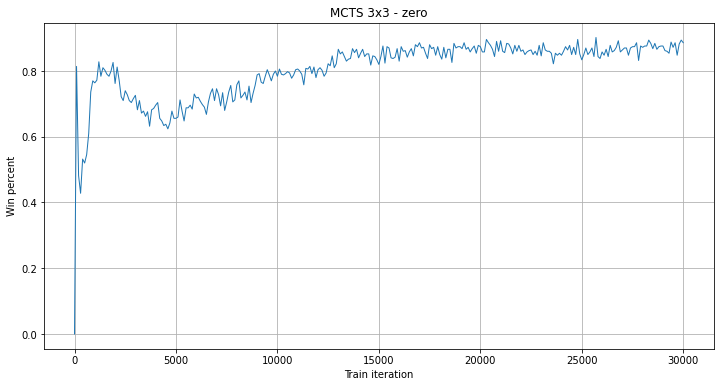

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('MCTS 3x3 - zero')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(mcts_p2.hist_iters, mcts_p2.hist, lw = 1)

### MCST 4x4

In [ ]:
SIZE = 4
env = TicTacToe(n_rows = SIZE, n_cols = SIZE, n_win = SIZE)
mcts_p1 = MCTS(env, exploration_const = 1.41, policy = random_policy, player = 1)

In [ ]:
mcts_p1.run_learning(n_iters = 500000, eval_every = 5000)

100%|██████████| 500000/500000 [22:05<00:00, 377.27it/s, player=1, win raito=0.912]


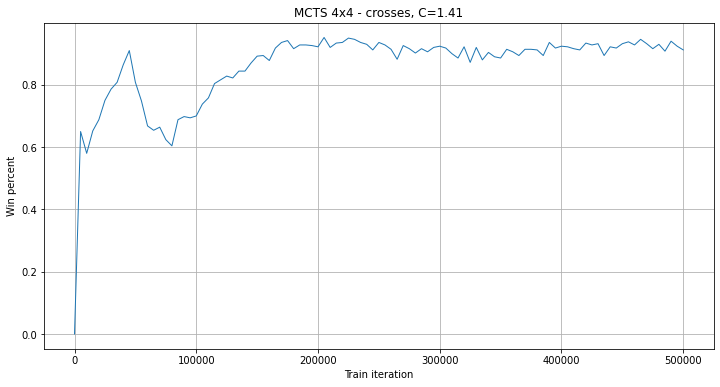

In [ ]:
plt.figure(figsize=(12, 6))
plt.title(f'MCTS 4x4 - crosses, C={mcts_p1.C}')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(mcts_p1.hist_iters, mcts_p1.hist, lw = 1);

In [ ]:
mcts_p2 = MCTS(env, exploration_const = 1.41, policy = random_policy, player = -1)

In [ ]:
mcts_p2.run_learning(n_iters = 500000, eval_every = 5000)

100%|██████████| 500000/500000 [40:06<00:00, 207.81it/s, player=-1, win raito=0.712]


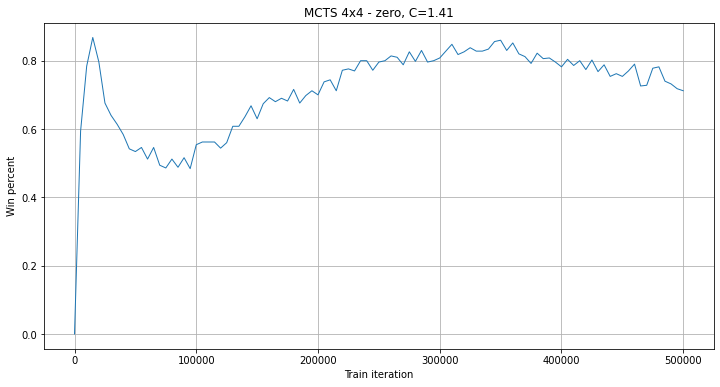

In [ ]:
plt.figure(figsize=(12, 6))
plt.title(f'MCTS 4x4 - zero, C={mcts_p2.C}')
plt.xlabel('Train iteration')
plt.ylabel('Win percent')
plt.grid(True)
plt.plot(mcts_p2.hist_iters, mcts_p2.hist, lw = 1)

MCTS is better than DQN and tend to be like Q-learning by perfomance in 3x3 field. But for 4x4 field MCTS spend a lot of time compare with Q-learning for training, but performance is better. I suppose that for 'zeros' with more iterations performance will stabilize, but here I spend a lot of time for training.